<a href="https://colab.research.google.com/github/leonardoLavagna/Drug-repurposing/blob/main/BI_LeoL_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!git clone https://github.com/dinaghiassian/DIAMOnD DiaBLE
!git clone https://github.com/dinaghiassian/DIAMOnD
#https://github.com/GuyAllard/markov_clustering
%pip install markov_clustering 
%pip install networkx --upgrade
%pip install scipy --upgrade

fatal: destination path 'DiaBLE' already exists and is not an empty directory.
fatal: destination path 'DIAMOnD' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import csv
import random
import json
import ast
import os
import sys
import statistics
import auxiliary_functions as AF
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import markov_clustering as mc
from tqdm import tqdm
from scipy.stats import hypergeom
from sklearn.model_selection import train_test_split

## TASK 1 

### PPI and GDA data gathering and interactome reconstruction

In [3]:
# FILE PATH
# Change according to your file system
# This path should be the same used in the auxiliary_funtions module

path = '/content/'

In [35]:
# DATA GATHERING AND PROCESSING

HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")
DGA_all = pd.read_csv(path+'curated_gene_disease_associations.tsv',sep='\t')
DGA =  DGA_all[DGA_all['diseaseName'] == 'Hypertensive disease']
DG_in_PPI,splits = AF.make_seeds_splits(DGA,HSN,'Hypertensive disease',path)
DG_in_PPI, splits = AF.import_seeds_split('Hypertensive disease')

Processing interactome...


<ipython-input-35-62efed7e1535>:3: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")


# Process completed.
Creating seed gene splits...
Number of genes in disease PPI:  290
# Process completed.
Importing seed genes...
# Process completed.


### Compute the disease LCC and its basic network measures

In [11]:
# LCC COMPUTATION

LCC = AF.extract_LCC_form_PPI(HSN)
n_nodes = LCC.number_of_nodes()

Extracting LCC...
Nodes  19618 , Connections  665061
# Process completed.


Creating Disease LCC graph...
Nodes in disease LCC  232
# Process completed.


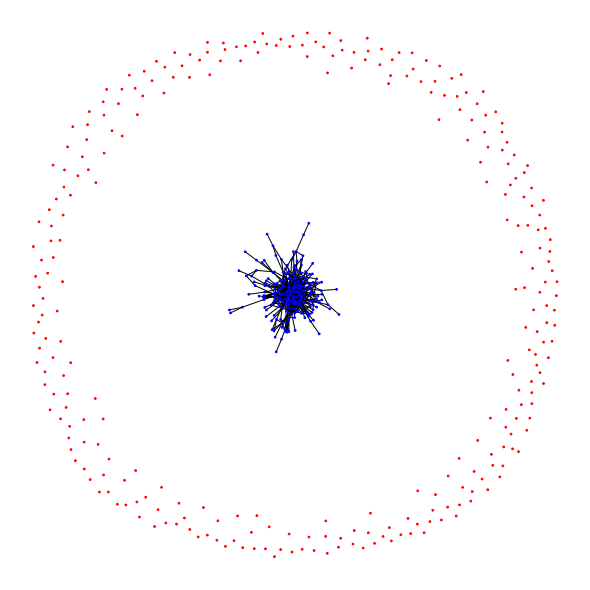

In [12]:
# LCC PLOT

DN = AF.make_disease_graph(HSN, DGA, DG_in_PPI)
AF.plot_LCC(DN, DG_in_PPI)

In [13]:
G = LCC.copy()

In [27]:
# LOCAL MEASURES
# This cell takes a while to run...

nx.set_node_attributes(G, G.degree(), 'Node degree')  
#nx.set_node_attributes(G, nx.betweenness_centrality(G), "Betweenness centrality")
nx.set_node_attributes(G, nx.eigenvector_centrality(G), "Eigenvector centrality")
#nx.set_node_attributes(G, nx.closeness_centrality(G), "Closeness centrality")

local_measures = pd.DataFrame(index=G.nodes())
local_measures['Node degree'] = [d for n, d in G.degree()] 
#local_measures['Betweenness centrality'] = pd.Series(nx.get_node_attributes(G, 'Betweenness centrality'))
local_measures['Eigenvector centrality'] = pd.Series(nx.get_node_attributes(G, 'Eigenvector centrality'))
#local_measures['Closeness centrality'] = pd.Series(nx.get_node_attributes(G, 'Closeness centrality'))
#local_measures['Betweenness/Degree Ratio'] = local_measures['Betweenness centrality']/local_measures['Node degree']
local_measures.index.name='Gene'

In [28]:
# TABLE OF LOCAL MEASURES

local_measures.to_csv('local_measures.csv', index = True, header = True)
local_measures = pd.read_csv('/content/local_measures.csv', sep=',')
local_measures.head()

,Gene,Node degree,Eigenvector centrality
0,MAP2K4,51,0.002493
1,MYPN,27,0.001812
2,ACVR1,54,0.001348
3,GATA2,58,0.002803
4,RPA2,546,0.032289


## Task 2 . Putative disease genes identification algorithms

### DIAMOnD algorithm

In [18]:
## AUXILIARY FUNCTIONS TO PUT IN FILE

def diamond(LCC, seeds, splits, i, top_n, path):
    # filtering the splits at i-th iteration
    filteredSymbolGenes_ID = DGA[DGA.geneSymbol.isin(splits[str(i)])].geneId.tolist()
    actualDt = list(set(seeds) - set(filteredSymbolGenes_ID))

    textfile = open("seed_gene.txt", "w")
    for element in actualDt:
      textfile.write(str(element) + '\n')
    textfile.close()
    
    pairs_genes = list(LCC.edges)
    textfile = open("PPI_Hypertensive.txt", "w")
    for gA, gB in tqdm(pairs_genes):
        textfile.write(str(gA) + ',' + str(gB) + '\n') 
    textfile.close()
    
    for x in [1000,500,250,100]:                            ###<-------------------------
        print(x, evaluation(x, cval = len(splits['0']), alg_name = 'DIAMOnD'))
    print('\n')

In [36]:
# Stores the seed genes
# For DIAMOnD we need to define two files, the PPI.txt and the seed_genes.txt:

seed_genes = DGA['geneId'].tolist()
textfile = open("seed_gene.txt", "w")
for element in seed_genes:
  if seed_genes.index(element) != len(seed_genes)-1:
    textfile.write(str(element) + "\n")
  else:
    textfile.write(str(element))
textfile.close()

In [37]:
# GENES

pairs_genes = list(LCC.edges)

In [38]:
# STORE HOMO SAPIENS INTERACTOME

textfile = open("PPI_Hypertensive.txt", "w")
for gA, gB in tqdm(pairs_genes):
  textfile.write(str(gA) + ',' + str(gB) + '\n') 
textfile.close()

100%|██████████| 665061/665061 [00:00<00:00, 930438.93it/s]


In [26]:
!pwd

/content


In [24]:
!mkdir results

In [25]:
!ls

 auxiliary_functions.py				  local_measures.csv
 BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt   PPI.adjlist
 curated_gene_disease_associations.tsv		  PPI_Hypertensive.txt
 DiaBLE						  __pycache__
 DIAMOnD					  results
'Hypertensive disease_seed_gene.txt'		  sample_data
'Hypertensive disease_splits.json'		  seed_gene.txt


In [42]:
# EXECUTE DIAMOND

with open(path+'Hypertensive disease_splits.json') as f:
  data = json.load(f)
  
filteredSymbolGenes_ID = DGA[DGA.geneSymbol.isin(data['4'])].geneId.tolist()
actualDt = list(set(seed_genes) - set(filteredSymbolGenes_ID))

textfile = open("seed_gene.txt", "w")
for element in actualDt:
  textfile.write(str(element) + '\n')
textfile.close()

!python3 /content/DIAMOnD/DIAMOnD.py PPI_Hypertensive.txt seed_gene.txt 200

DIAMOnD(): ignoring 245 of 245 seed genes that are not in the network
Traceback (most recent call last):
  File "/content/DIAMOnD/DIAMOnD.py", line 451, in <module>
    added_nodes = DIAMOnD(G_original,
  File "/content/DIAMOnD/DIAMOnD.py", line 401, in DIAMOnD
    added_nodes = diamond_iteration_of_first_X_nodes(G_original,
  File "/content/DIAMOnD/DIAMOnD.py", line 347, in diamond_iteration_of_first_X_nodes
    info[next_node][0],
KeyError: 'nix'


### DiaBLE algorithm

In [12]:
# EXECUTE DIABLE
# Change the code in the DIAMOnD script in the DiaBLE Folder (see below)

!python3 /content/DiaBLE/DIAMOnD.py PPI_Hypertensive.txt seed_gene.txt 1000

DIAMOnD(): ignoring 245 of 245 seed genes that are not in the network
Traceback (most recent call last):
  File "/content/DiaBLE/DIAMOnD.py", line 451, in <module>
    added_nodes = DIAMOnD(G_original,
  File "/content/DiaBLE/DIAMOnD.py", line 401, in DIAMOnD
    added_nodes = diamond_iteration_of_first_X_nodes(G_original,
  File "/content/DiaBLE/DIAMOnD.py", line 347, in diamond_iteration_of_first_X_nodes
    info[next_node][0],
KeyError: 'nix'


AFTER LINE 317 CHANGE AS FOLLOWS: ADD THE LINES

```
  candidates = set(cluster_nodes)
  universe = set()

  for _ in range(0, 2):
    for gene in candidates.copy():
      universe |= neighbors[gene]
    candidates = universe        
  
  N = len(universe)
```


### Diffusion Based Algorithm

In [ ]:
#..... ??

### Validation

In [43]:
## AUXILIARY FUNCTIONS TO PUT IN FILE

def cross_vaidation(splits,nodes,DG_in_PPI,clusters,DGA_filt,n_size=n_nodes):
    print("Executing cross validation...")
    recall = {'std_valid':[],'ext_valid':[]}
    prec =  {'std_valid':[],'ext_valid':[]}
    f1 =  {'std_valid':[],'ext_valid':[]}
    enriched_clusters = 0
    for idx in range(0,5):
        test = set(splits[str(idx)])
        training = set(DG_in_PPI).difference(test)
        positives = set()
        for cluster in clusters:
            N = n_size
            K = len(training)
            n = len(cluster)
            k = len(set(nodes[list(cluster)]).intersection(training))+10e-10
            pval = hypergeom.sf(k=k-1, M=N, n=K, N=n)
            if pval < 0.05:
                enriched_clusters += 1
                positives = positives.union(set(nodes[list(cluster)]))
        TP = test.intersection(positives)
        FP = positives.difference(test)
        FN = test.difference(positives)
        r,p,f = metrics(TP,FP,FN)
        R,P,F = metrics(FP.intersection(DGA_filt), FP.difference(DGA_filt), DGA_filt.difference(TP.union(FN)))
        recall['std_valid'] += [r]
        prec['std_valid'] += [p]
        f1['std_valid'] += [f]
        recall['ext_valid'] += [R]
        prec['ext_valid'] += [P]
        f1['ext_valid'] += [F]
     
    print('Enriched Clusters:',enriched_clusters/5)
    print("# Process completed.")
    return recall,prec,f1
    

def metrics(TP,FP,FN):
    print("Calculating matricses...")
    recall = len(TP)/(len(TP)+len(FP)+10e-10)
    prec = len(TP)/(len(TP)+len(FN)+10e-10)
    f1 = 2*(recall/5*prec/5)/(prec/5+recall/5+10e-10)
    print("# Process completed.")
    return recall, prec, f1


def calculate_dcg(inters, cv, alg_name):
  # Discounted cumulative gain
  print("Evaluating DCG...")
  dcg = 0
  try:
    for dis_gene in inters:
      rank = cv.loc[cv[alg_name + '_node'] == dis_gene].index.tolist()[0]
      dcg += 1/np.log2(rank+1)
  except:
    dcg += 0
  print("# Process completed.")
  return dcg


def normalized_dcg(ndcg_scores):
  print("Evaluationg normalized DCG....")
  list_=list(np.around(np.array(ndcg_scores)/np.max(ndcg_scores), 3)) 
  print("# Process completed.")
  return list_ 


def evaluation(top_n, cval, alg_name):
    print("Executing evaluation....")
    recalls, precs, f1s, ndcg_scores = ([] for _ in range(4))
    cv = pd.read_csv(f'first_1000_added_nodes_weight_1.txt',sep='\t')###<-------------------------
    cv_nodes = cv[alg_name + '_node'].tolist()

    # subsets (by 1000, etc...)
    top = set(cv_nodes[0:top_n]) 

    # intersection with the probe set
    inters = top.intersection(geneDiseaseIDs[str(i)]) 

    # Calculating DCG
    dcg = calculate_dcg(inters, cv, alg_name)

    # Appending  results
    recall = round(len(inters)/cval, 3)
    prec = round(len(inters)/top_n, 3)
    recalls.append(recall)
    precs.append(prec)
    ndcg_scores.append(round(dcg, 3))

    try:
      f1s.append(round(2*((recall*prec)/(recall+prec)), 3))
    except:
      f1s.append(0)

    print("# Process completed")
    return {'recall': recalls, 
            'precision': precs, 
            'F1 Score': f1s, 
            'ndcg': normalized_dcg(ndcg_scores)}

#### Cross-Validation splits

In [44]:
# SET UP

with open('/content/Hypertensive disease_splits.json') as f:
  dict_ = json.load(f)

with open('/content/Hypertensive disease_seed_gene.txt') as f:
  seeds = pd.read_csv(f,sep='\t',header=None)

gene_dis_association = pd.read_csv('/content/curated_gene_disease_associations.tsv', sep = '\t')
gene_dis_association = gene_dis_association[gene_dis_association['diseaseName'] == 'Hypertensive disease']

seeds=seeds[0].to_numpy()
seeds

array(["['CD2AP', 'MMP2', 'TPM1', 'WT1', 'ICAM1', 'JUN', 'CLCNKA', 'GCH1', 'GSK3B', 'ANXA1', 'SLC37A4', 'NOS2', 'HRH3', 'INS', 'CXCL2', 'GAL', 'PRKACA', 'NPTN', 'CRHR2', 'ITM2B', 'COL1A1', 'IER3', 'CACNA1C', 'WDPCP', 'MFAP5', 'LEP', 'TGFB1', 'PTH', 'ZMPSTE24', 'VHL', 'KCNMB1', 'CCL2', 'NCF1', 'TGFB2', 'MYH11', 'BMPR2', 'FGA', 'F11', 'SCNN1G', 'GLP1R', 'GPX1', 'GSTT1', 'FXYD2', 'PRKCD', 'STIM1', 'TGFB3', 'CALCA', 'PPARG', 'ATP2B1', 'COL4A3', 'TRAF3IP1', 'LOX', 'PPBP', 'AOC1', 'IL6', 'USP8', 'LPL', 'LMNA', 'NPR1', 'COX3', 'STK39', 'CPOX', 'ACT', 'MYLK', 'BBS7', 'TP53', 'ATP2B3', 'ERCC8', 'CALR', 'GSTA5', 'CETP', 'ACE2', 'THPO', 'CRP', 'SCNN1B', 'STK11', 'GNAS', 'AGTR1', 'CYBB', 'NME1', 'EDNRA', 'NPPA', 'AGTR2', 'KCNJ5', 'DYRK1B', 'CYP21A2', 'GUCY1A3', 'MKS1', 'BBS4', 'PPP1R3A', 'ECE1', 'SERPINE1', 'OXSR1', 'IGF1', 'NEDD4L', 'APOE', 'LTF', 'MUC1', 'PAX2', 'ERAP1', 'SLC12A2', 'OXT', 'CYTB', 'SOD3', 'KCNJ1', 'CD36', 'FGFR2', 'PLG', 'ALOX15', 'TNF', 'LDLR', 'FN1', 'NR3C2', 'RGS2', 'UCN', 'MC

In [45]:
# CROSS VALIDATION SPLITS INTO FILES

for k,v in dict_.items():
    print(k,v)
    ids=gene_dis_association.loc[gene_dis_association.geneSymbol.isin(v)].geneId.tolist()
    l=list(set(seeds).difference(set(ids)))
    with open('/content/cross_{}.txt'.format(k),'w') as f:
        for item in l:
            f.write("%s\n" % item)
    

0 ['CD2AP', 'MMP2', 'TPM1', 'WT1', 'ICAM1', 'JUN', 'CLCNKA', 'GCH1', 'GSK3B', 'ANXA1', 'SLC37A4', 'NOS2', 'HRH3', 'INS', 'CXCL2', 'GAL', 'PRKACA', 'NPTN', 'CRHR2', 'ITM2B', 'COL1A1', 'IER3', 'CACNA1C', 'WDPCP', 'MFAP5', 'LEP', 'TGFB1', 'PTH', 'ZMPSTE24', 'VHL', 'KCNMB1', 'CCL2', 'NCF1', 'TGFB2', 'MYH11', 'BMPR2', 'FGA', 'F11', 'SCNN1G', 'GLP1R', 'GPX1', 'GSTT1', 'FXYD2', 'PRKCD', 'STIM1', 'TGFB3', 'CALCA', 'PPARG', 'ATP2B1', 'COL4A3', 'TRAF3IP1', 'LOX', 'PPBP', 'AOC1', 'IL6', 'USP8', 'LPL', 'LMNA']
1 ['NPR1', 'COX3', 'STK39', 'CPOX', 'ACT', 'MYLK', 'BBS7', 'TP53', 'ATP2B3', 'ERCC8', 'CALR', 'GSTA5', 'CETP', 'ACE2', 'THPO', 'CRP', 'SCNN1B', 'STK11', 'GNAS', 'AGTR1', 'CYBB', 'NME1', 'EDNRA', 'NPPA', 'AGTR2', 'KCNJ5', 'DYRK1B', 'CYP21A2', 'GUCY1A3', 'MKS1', 'BBS4', 'PPP1R3A', 'ECE1', 'SERPINE1', 'OXSR1', 'IGF1', 'NEDD4L', 'APOE', 'LTF', 'MUC1', 'PAX2', 'ERAP1', 'SLC12A2', 'OXT', 'CYTB', 'SOD3', 'KCNJ1', 'CD36', 'FGFR2', 'PLG', 'ALOX15', 'TNF', 'LDLR', 'FN1', 'NR3C2', 'RGS2', 'UCN', 'MC2R'

In [46]:
# CHECK

print(splits)

{'0': ['CD2AP', 'MMP2', 'TPM1', 'WT1', 'ICAM1', 'JUN', 'CLCNKA', 'GCH1', 'GSK3B', 'ANXA1', 'SLC37A4', 'NOS2', 'HRH3', 'INS', 'CXCL2', 'GAL', 'PRKACA', 'NPTN', 'CRHR2', 'ITM2B', 'COL1A1', 'IER3', 'CACNA1C', 'WDPCP', 'MFAP5', 'LEP', 'TGFB1', 'PTH', 'ZMPSTE24', 'VHL', 'KCNMB1', 'CCL2', 'NCF1', 'TGFB2', 'MYH11', 'BMPR2', 'FGA', 'F11', 'SCNN1G', 'GLP1R', 'GPX1', 'GSTT1', 'FXYD2', 'PRKCD', 'STIM1', 'TGFB3', 'CALCA', 'PPARG', 'ATP2B1', 'COL4A3', 'TRAF3IP1', 'LOX', 'PPBP', 'AOC1', 'IL6', 'USP8', 'LPL', 'LMNA'], '1': ['NPR1', 'COX3', 'STK39', 'CPOX', 'ACT', 'MYLK', 'BBS7', 'TP53', 'ATP2B3', 'ERCC8', 'CALR', 'GSTA5', 'CETP', 'ACE2', 'THPO', 'CRP', 'SCNN1B', 'STK11', 'GNAS', 'AGTR1', 'CYBB', 'NME1', 'EDNRA', 'NPPA', 'AGTR2', 'KCNJ5', 'DYRK1B', 'CYP21A2', 'GUCY1A3', 'MKS1', 'BBS4', 'PPP1R3A', 'ECE1', 'SERPINE1', 'OXSR1', 'IGF1', 'NEDD4L', 'APOE', 'LTF', 'MUC1', 'PAX2', 'ERAP1', 'SLC12A2', 'OXT', 'CYTB', 'SOD3', 'KCNJ1', 'CD36', 'FGFR2', 'PLG', 'ALOX15', 'TNF', 'LDLR', 'FN1', 'NR3C2', 'RGS2', 'UCN'

In [47]:
# DICTIONARY WITH SPLITS MAPPING

geneDiseaseIDs = {
    '0': DGA[DGA.geneSymbol.isin(splits['0'])].geneId.tolist(),
    '1': DGA[DGA.geneSymbol.isin(splits['1'])].geneId.tolist(),
    '2': DGA[DGA.geneSymbol.isin(splits['2'])].geneId.tolist(),
    '3': DGA[DGA.geneSymbol.isin(splits['3'])].geneId.tolist(),
    '4': DGA[DGA.geneSymbol.isin(splits['4'])].geneId.tolist()
}

#### Evaluation of performances

In [ ]:
# DIAMOND 

for i in range(0, 5):
    diamond(LCC, DG_in_PPI, splits, i, top_n = 1000, path = '...')###<-------------------------
    # path = diamond results 

In [ ]:
# DIABLE

for i in range(0, 5):
    diamond(LCC, DG_in_PPI, splits, i, top_n = 1000, path = '...')###<-------------------------

In [ ]:
# DIFFUSION BASED

#... ?

## Optional Task 3 MCL

In [ ]:
# SET UP

curated_gene_desease_association_DF = pd.read_csv("/content/curated_gene_disease_associations.tsv", sep = '\t', compression = 'infer')
disease_DF = curated_gene_desease_association_DF.loc[curated_gene_desease_association_DF['diseaseId'] == 'C0020538']

In [ ]:
# SEED GENES

seed_list = list(disease_DF['geneId'])
seed_genes_symbols = list(disease_DF['geneSymbol'])

In [ ]:
# CLUSTERS

result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))           
clusters = mc.get_clusters(result) 

In [ ]:
# PLOT

mc.draw_graph(nx.to_scipy_sparse_matrix(G), clusters, node_size=10, with_labels=False, edge_color="silver")

In [ ]:
# PERFORM CLUSTERING
# Use different inflation values from 1.5 and 2.5
# for each clustering run calculate the modularity

matrix = nx.to_scipy_sparse_matrix(G)
for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

Now that we have found the clusters, we filter them in order to keep only those having at least 10 nodes and in which the seed genes are statistically overrepresented. The resulting sets are the putative desease modules.

In [ ]:
# KEEP CLUSTERS WITH AT LEAST 10 GENES

big_clusters = []
for module in clusters:
    if len(module) >= 10:
        big_clusters.append(module)
print(len(clusters), len(big_clusters))

In [ ]:
# DICTIONARY WITH MAPPING {nodeID : gene name}

val = range(G.number_of_nodes())
names = list(G.nodes())
dic = dict(zip(val, names))

In [ ]:
# RUN THE HYPERGEOMETRIC TEST TO FIND MODULES WITH STATISTICALLY OVERREPRESENTED SEED GENES

putative_desease_modules = []
M = G.number_of_nodes() # population size (total number of genes) 
n = len(seed_genes_symbols) # number of seed genes
p_val_list = []
for module in big_clusters:
    N = len(module) # number of draws (number of genes in the given cluster)
    x = len(set(seed_genes_symbols).intersection(set(dic[g] for g in module)))
    p_val = hypergeom.sf(x-1, M, n, N)
    if p_val < 0.05:
        putative_desease_modules.append(module)
        p_val_list.append(p_val)

In [ ]:
# PUTATIVE DISEASE MODULES TO PUT IN THE FOLLOWING DATAFRAME

for i in range(len(putative_desease_modules)):
    print("Desease putative module ",i, ": ", *[dic[g] for g in putative_desease_modules[i]])

In [ ]:
# DATAFRAME OF PUTATIVE DISEASE MODULES

header = ['ModuleID', "Number of seed genes/module", "Module size", "Seed genes", "All genes", "p-value"]
df_putative_desease_modules = pd.DataFrame(columns=header)
for i in range(len(putative_desease_modules)):
    seeds = set(seed_genes_symbols).intersection(set(dic[g] for g in putative_desease_modules[i]))
    values = [i, len(seeds), len(putative_desease_modules[i]), seeds, [dic[g] for g in putative_desease_modules[i]],p_val_list[i]]
    df = pd.DataFrame( [values], columns = header)
    df_putative_desease_modules = df_putative_desease_modules.append(df, ignore_index=True)

In [ ]:
# CHECK

df_putative_desease_modules